# Анализ оттока клиентов из фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет. Поставлена задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

### Оглавление
1. [Открытие данных](#open)

2. [Исследовательский анализ данных (EDA)](#analysis)
    
3. [Модель прогнозирования оттока клиентов](#model)    

4. [Кластеризация клиентов](#kmeans)

5. [Выводы и рекомендации](#concl)


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

## Открытие данные
<a id="open"></a>

In [2]:
# функция для удобства чтения файлов локально и на сервере школы

def read_csv(file):
    file = 'datasets/' + file + '.csv'
    try:
        return pd.read_csv('/' + file, sep=',', decimal=',')
    except FileNotFoundError:
        return pd.read_csv(file, sep=',', decimal=',')

In [3]:
gym_churn = read_csv('gym_churn')
gym_churn.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470422861144,5.0,3,0.02039794762085778,0.0,0
1,0,1,0,0,1,12,1,31,113.20293765105819,12.0,7,1.9229360550418195,1.9102435215196407,0
2,0,1,1,0,1,1,0,28,129.44847933200614,1.0,2,1.8590983473832376,1.7365018916344137,0
3,0,1,1,1,1,12,1,33,62.66986319123829,12.0,2,3.2056327682385,3.3572145130526616,0
4,1,1,1,1,1,1,0,26,198.36226543903683,1.0,3,1.1138844004257795,1.120078107422207,0


Для удобства работы приведем названия столбцов к нижнем регистру.

In [4]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

## Проведем исследовательский анализ данных (EDA)
<a id="analysis"></a>

- Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения;

In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   gender                             4000 non-null   int64 
 1   near_location                      4000 non-null   int64 
 2   partner                            4000 non-null   int64 
 3   promo_friends                      4000 non-null   int64 
 4   phone                              4000 non-null   int64 
 5   contract_period                    4000 non-null   int64 
 6   group_visits                       4000 non-null   int64 
 7   age                                4000 non-null   int64 
 8   avg_additional_charges_total       4000 non-null   object
 9   month_to_end_contract              4000 non-null   object
 10  lifetime                           4000 non-null   int64 
 11  avg_class_frequency_total          4000 non-null   object
 12  avg_cl

Имеются данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Некоторые столбцы имеют тип object - исправим это: 

In [6]:
gym_churn['avg_additional_charges_total'] = gym_churn['avg_additional_charges_total'].astype('float')
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('float')
gym_churn['avg_class_frequency_total'] = gym_churn['avg_class_frequency_total'].astype('float')
gym_churn['avg_class_frequency_current_month'] = gym_churn['avg_class_frequency_current_month'].astype('float')

gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков нет. Типы данных исправлены. Изучим средние значения и стандартные отклонения: 

In [7]:
gym_churn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Данные выглядят реалистично. По средним значениям можно сказать, что гендерное распределение практически пополам, большинство посетителей центра живут или работают рядом, почти половина приходит от компаний-партнеров, а треть - через друзей, средний возраст посетителя 29 лет, чаще всего ходят в зал пару раз в неделю.

Изучив минимальные и максимальные значения и стандартные отклонения, видно, что выбросов нет. Даже в "avg_additional_charges_total" значения в 75% не сильно отличаются от максимума, "lifetime" имеет разницу больше, тем не менее 31 месяц вполне реалистичное время - не будем считать это выбросом. Можем продолжить работать с данными.

- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;

In [8]:
mean_pivot = pd.pivot_table(gym_churn, index='churn', aggfunc='mean')
mean_pivot.transpose()

churn,0,1
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
avg_class_frequency_current_month,2.027882,1.044546
avg_class_frequency_total,2.024876,1.474995
contract_period,5.747193,1.728558
gender,0.510037,0.510839
group_visits,0.464103,0.268615
lifetime,4.711807,0.990575
month_to_end_contract,5.283089,1.662582
near_location,0.873086,0.768143


"Культуристы", ушедшие в отток моложе, реже занимались, также намного меньше из этих людей были приглашены друзьями или пришли через компании-партнеров. Еще можно сказать, что они реже посещают групповые занятия, живут или работают дальше от зала и изначально оформляли короткие контракты. Гендерных различий нет.

- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

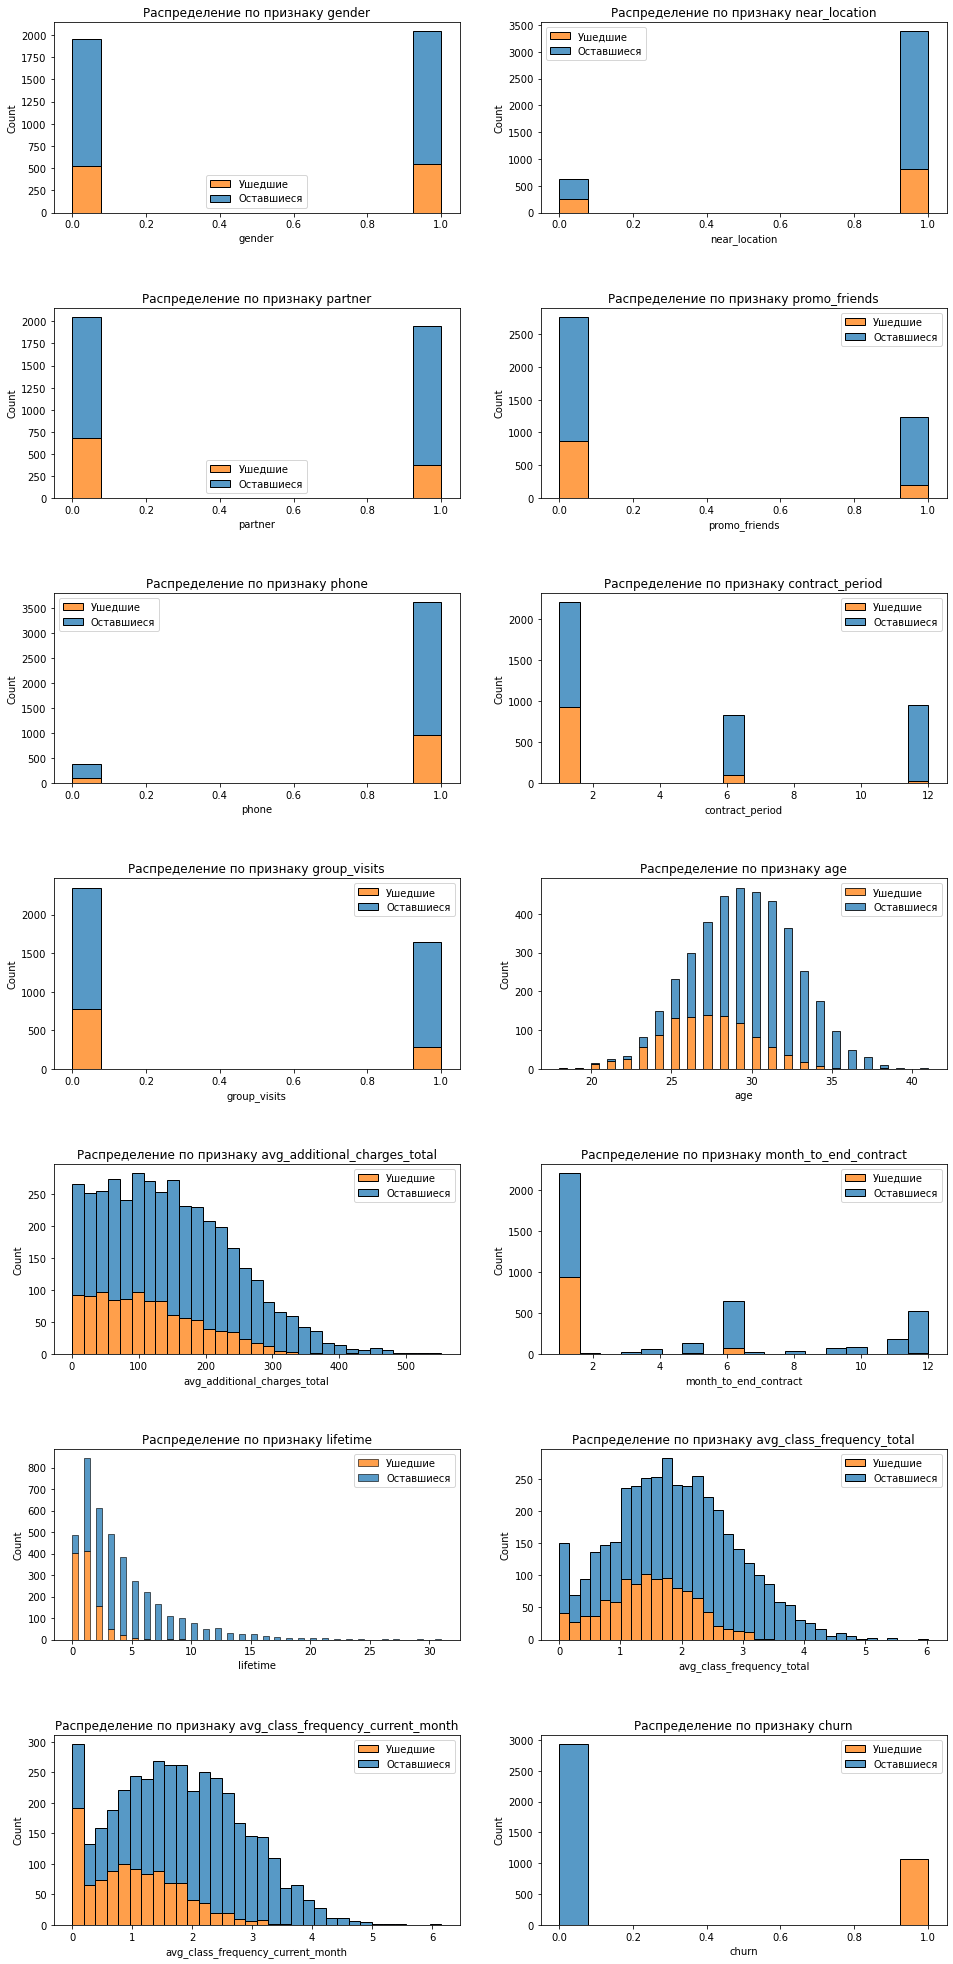

In [9]:
plt.figure(figsize=(16, 35))

for i, name in enumerate(gym_churn.columns, 1):
    plt.subplot(7, 2, i)

    ax = sns.histplot(gym_churn, x=name, hue="churn", palette='tab10', multiple='stack')
    ax.legend(['Ушедшие', 'Оставшиеся'])
    
    plt.subplots_adjust(hspace = 0.5)
    
    
    plt.title('Распределение по признаку ' + name)
    
plt.show()

Графики подтвеждают ранее сделанные нами выводы.

- Построим матрицу корреляций и отобразим её.

In [10]:
gym_churn.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


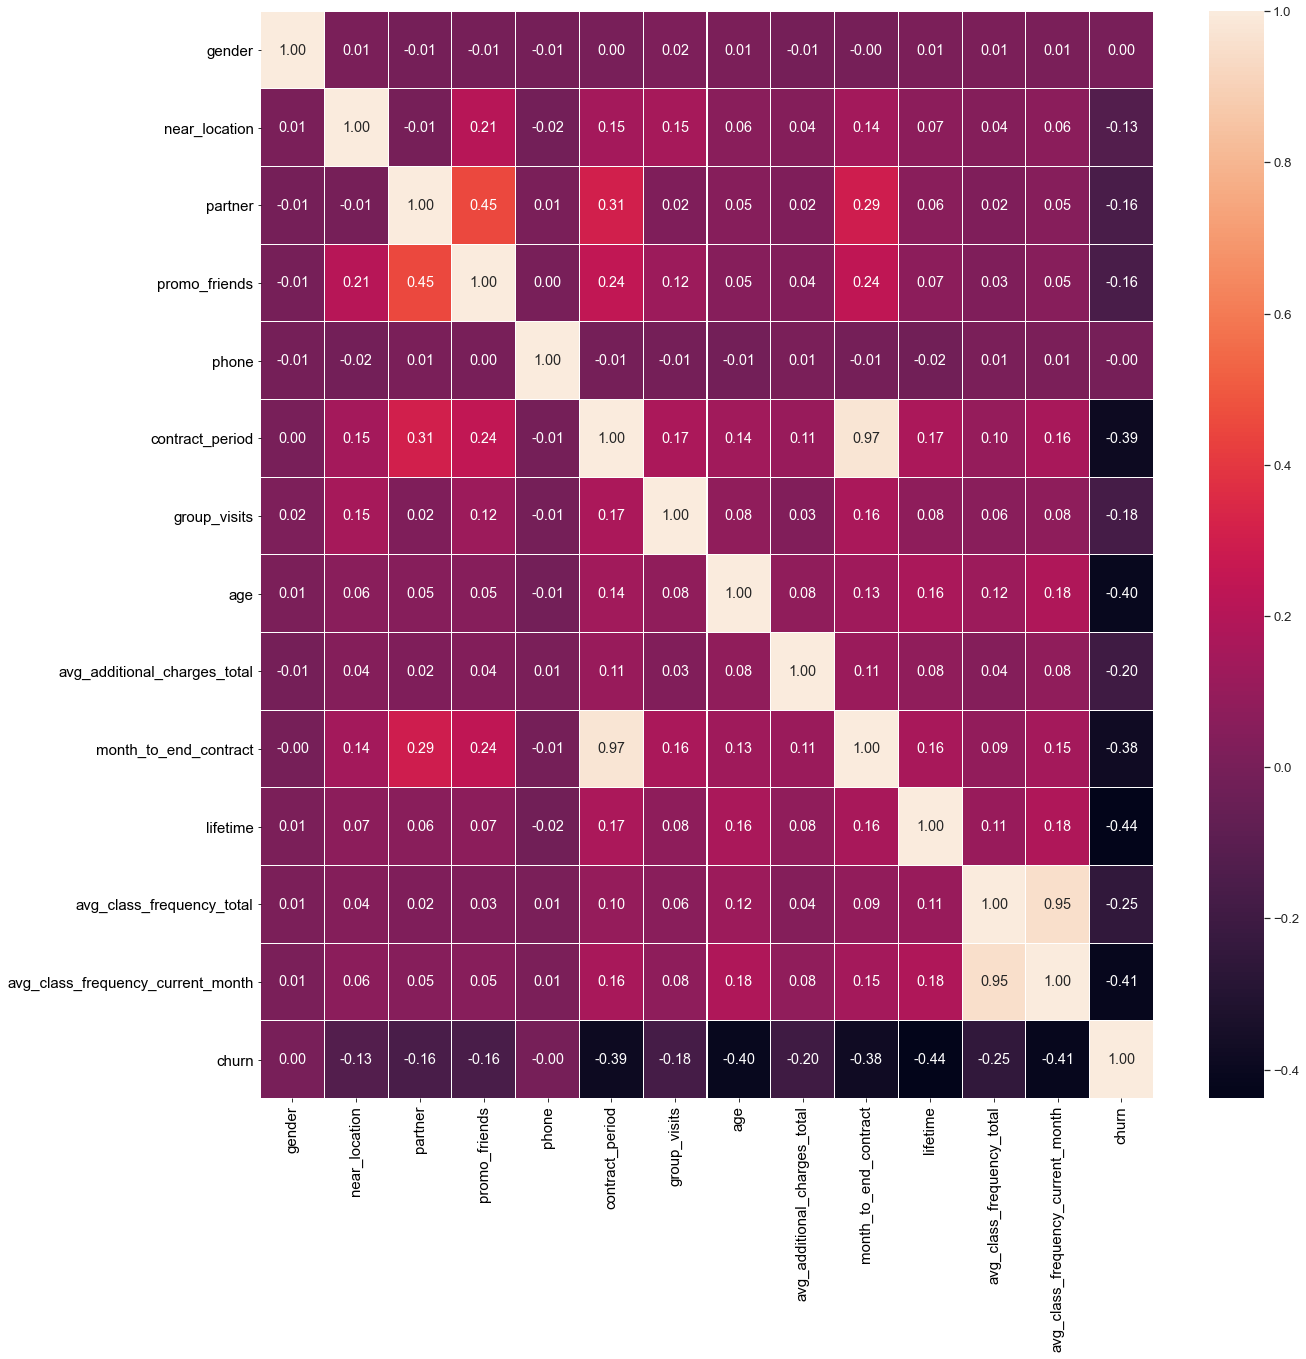

In [11]:
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)

fig = sns.heatmap(gym_churn.corr(), annot = True, fmt=".2f", linewidths=0.1, linecolor='white')

_ = fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 15)
_ = fig.set_yticklabels(fig.get_ymajorticklabels(), fontsize = 15)

Можно выделить признаки с наиболее высокой корреляцией:
- 'month_to_end_contract' и 'contract_period' 
- 'avg_class_frequency_total' и 'avg_class_frequency_current_month'

Cразу можем сказать, что признаки взаимозависимые. При обучении модели также используем данные с одним из коррелируемых признаков, понизив мультиколлинеарность.

## Построим модель прогнозирования оттока клиентов
<a id="model"></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

- Разобьем данные на обучающую и валидационную выборку функцией train_test_split().

In [12]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)

X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

In [13]:
# разделяем модель на обучающую и валидационную выборку

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

- Обучим модель на train-выборке двумя способами:

    - логистической регрессией,
    - случайным лесом.

Посмотрим как повлияет стандартизация на обучение. 

In [14]:
# стандартизируем данные 
scaler = StandardScaler()

scaler.fit(X_train) # обучаем scaler на обучающей выборке методом fit

X_train_st = scaler.transform(X_train) # стандартизируем обучающую выборку методом transform scaler 
X_test_st = scaler.transform(X_test) # стандартизируем тестовую выборку методом transform scaler

In [15]:
# создадим также сет, убрав взаимосвязанные признаки

X_train_cleared = X_train.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])
X_test_cleared = X_test.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])

Логистическая регрессия:

In [16]:
# задайте алгоритм для нашей модели

model_st = LogisticRegression(solver='liblinear') 
model = LogisticRegression(solver='liblinear') 
model_cleared = LogisticRegression(solver='liblinear') 

In [17]:
# обучим модель

model_st.fit(X_train_st, y_train)
model.fit(X_train, y_train)
model_cleared.fit(X_train_cleared, y_train)

LogisticRegression(solver='liblinear')

In [18]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы

predictions_st = model_st.predict(X_test_st)
predictions = model.predict(X_test)
predictions_cleared = model_cleared.predict(X_test_cleared)

In [19]:
# получим вероятности

probabilities_st = model_st.predict_proba(X_test_st)[:,1]
probabilities = model.predict_proba(X_test)[:,1]
probabilities_cleared = model_cleared.predict_proba(X_test_cleared)[:,1]

Cлучайный лес:

In [20]:
# зададим алгоритм для новой модели на основе алгоритма решающего дерева
rf_model = RandomForestClassifier(random_state=0)

rf_model.fit(X_train, y_train) # обучим модель

RandomForestClassifier(random_state=0)

In [21]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы

rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.

Логистическая регрессия:

In [22]:
print(
'accuracy_score: {:.2f} \naccuracy_score_st: {:.2f} \naccuracy_score_11: {:.2f}'.format(
            accuracy_score(y_test, predictions),
            accuracy_score(y_test, predictions_st),
            accuracy_score(y_test, predictions_cleared)
        ))

accuracy_score: 0.93 
accuracy_score_st: 0.92 
accuracy_score_11: 0.88


In [23]:
print(
'precision_score: {:.2f} \nprecision_score_st: {:.2f} \nprecision_score_11: {:.2f}'.format(
            precision_score(y_test, predictions),
            precision_score(y_test, predictions_st),
            precision_score(y_test, predictions_cleared)
        ))

precision_score: 0.86 
precision_score_st: 0.85 
precision_score_11: 0.76


In [24]:
print(
'recall_score: {:.2f} \nrecall_score_st: {:.2f} \nrecall_score_11: {:.2f}'.format(
            recall_score(y_test, predictions),
            recall_score(y_test, predictions_st),
            recall_score(y_test, predictions_cleared)
        ))

recall_score: 0.83 
recall_score_st: 0.83 
recall_score_11: 0.77


Случайный лес:

In [25]:
print('accuracy_score_rf: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))

accuracy_score_rf: 0.92


In [26]:
print('precision_score_rf: {:.2f}'.format(precision_score(y_test, rf_predictions)))

precision_score_rf: 0.84


In [27]:
print('recall_score_rf: {:.2f}'.format(recall_score(y_test, rf_predictions)))

recall_score_rf: 0.82


Лучшие результаты показала логистическая регрессия, обученная на нестандартизированных признаках. Если удалить скоррелированные признаки, то качество становится хуже.

## Сделаем кластеризацию клиентов
<a id="kmeans"></a>

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов):

- Стандартизируем данные.

In [28]:
scaler = StandardScaler()

X_st = scaler.fit_transform(X)

- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

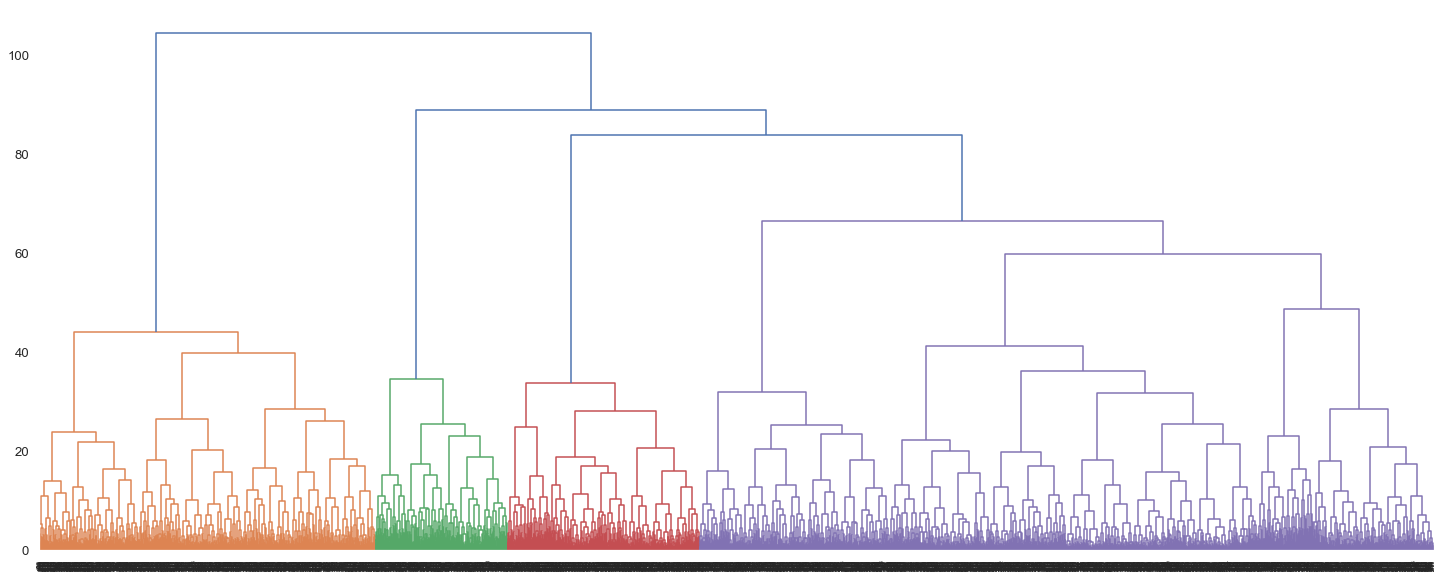

In [29]:
linked = linkage(X_st, method = 'ward')

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linked)

plt.show()

Дендограмма построила четыре кластера, тем не менее четвертый кластер довольно широкий и скорее всего мы можем разделить его на два. Предположим, что у нас пять групп клиентов.

- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Примем число кластеров n=5. 

In [30]:
# задаём модель k_means с числом кластеров 5

km = KMeans(n_clusters = 5, random_state=42)

In [31]:
# прогнозируем кластеры для наблюдений

labels = km.fit_predict(X_st)

In [32]:
# выведем уникальные значения кластеров

set(labels)

{0, 1, 2, 3, 4}

- Посмотрим на средние значения признаков для кластеров. 

In [33]:
# добавим labels в изначальную таблицу

gym_churn['labels'] = labels +1 #прибавим единицу для удобства, чтобы не было нулевого кластера

In [34]:
mean_pivot = pd.pivot_table(gym_churn, index='labels', aggfunc='mean')
mean_pivot.transpose()

labels,1,2,3,4,5
age,28.477228,29.301299,28.165741,30.114657,29.991027
avg_additional_charges_total,135.457501,143.957664,131.686305,161.376306,160.881742
avg_class_frequency_current_month,1.477324,1.716369,1.012716,2.846788,1.970029
avg_class_frequency_total,1.660461,1.847220,1.247327,2.848556,1.977676
churn,0.443564,0.267532,0.514671,0.067376,0.027916
contract_period,2.352475,4.787013,1.953212,2.689125,10.923230
gender,0.495050,0.522078,0.484536,0.560284,0.503490
group_visits,0.215842,0.425974,0.340999,0.470449,0.546361
lifetime,2.809901,3.924675,2.432197,4.892435,4.748754
month_to_end_contract,2.198020,4.475325,1.861221,2.479905,9.983051


Можно выделить некоторые характеристики групп клиентов:

- Первый кластер: живут/работают далеко от центра, многие пришли через партнерские компании, большой процент таких клиентов уходит;


- Второй кластер: похожи на первый кластер, но отличаются тем, что живут/работают ближе, а также менее склонны к уходу; 


- Третий кластер: меньше всех занимаются, несмотря на то, что живут ближе всех, заключают самые короткие контракты, половина из них уходит;


- Четвертый кластер: клиенты постарше, занимаются чаще всех, живут/работают очень близко, также тратят больше всех денег на дополнительные сервисы центра;


- Пятый кластер: заключают самые долгосрочные контракты, явно любят дополнительные сервисы центра и тратят на них деньги, любят групповые занятия, живут/работают близко и многие пришли через друзей или компании-партнеры. 


- Построим распределения признаков для кластеров.

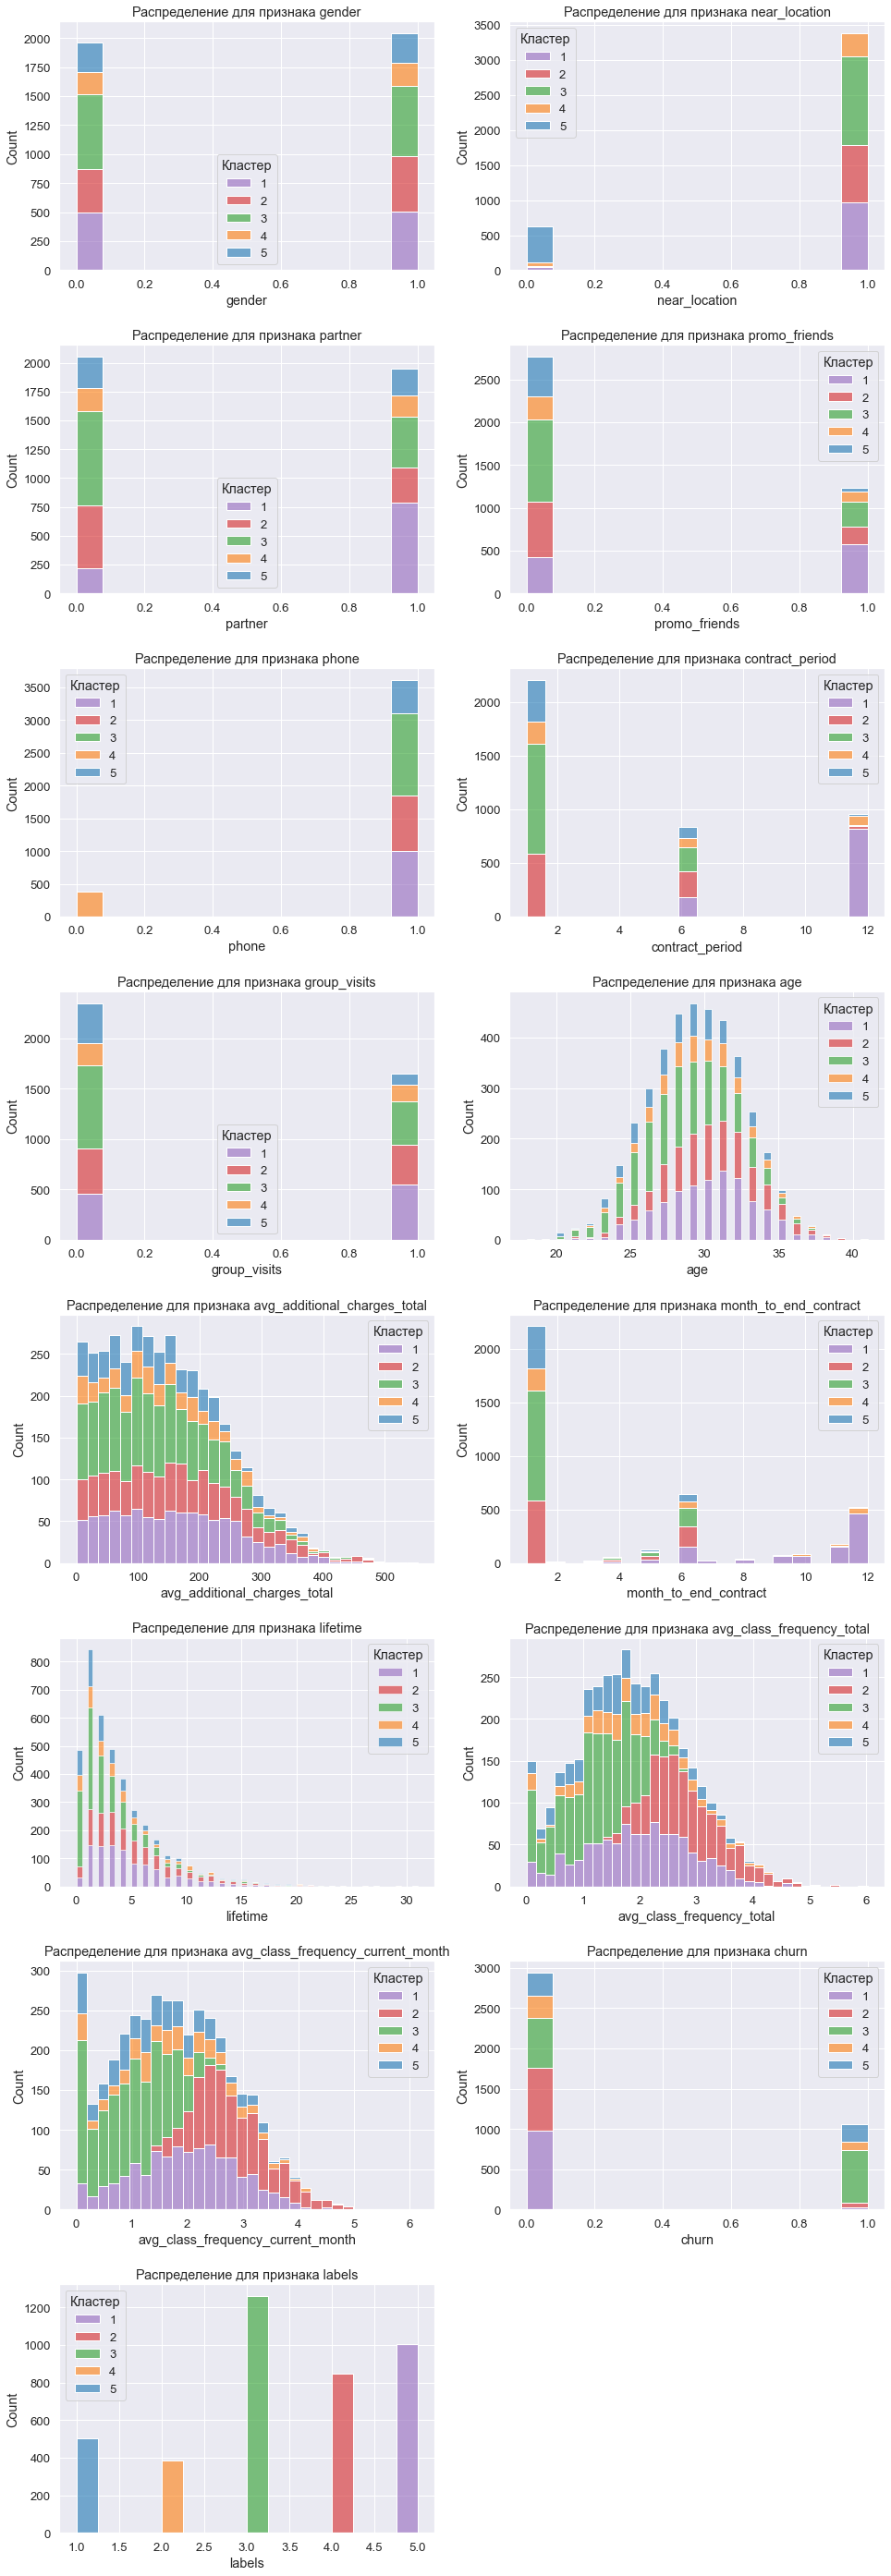

In [35]:
plt.figure(figsize=(16, 50))

i = 0
for name in gym_churn.columns:
    i += 1
    plt.subplot(8, 2, i)
    ax = sns.histplot(gym_churn, x=name, hue="labels", palette='tab10', alpha=0.6, multiple='stack')
    
    ax.legend([1, 2, 3, 4, 5], title='Кластер')
    
    plt.subplots_adjust(hspace = 0.3)
    
    plt.title('Распределение для признака ' + name)
    
plt.show()

Графики подтверждают сделанные нами ранее выводы. Также можем отметить, что третий кластер наиболее многочисленный по количеству клиентов в нем.

- Для каждого полученного кластера посчитаем долю оттока. Определим какие кластеры склонны к оттоку, а какие — надёжны.

In [36]:
gym_churn.groupby('labels').agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
labels,
3,0.514671
1,0.443564
2,0.267532
4,0.067376
5,0.027916


**Третий и первый кластеры наиболее склонны к оттоку**, это те клиенты, которые либо живут/работают дальше всех от фитнес-центра и скорее всего в связи с этим занимаются реже всех, либо это люди с изначально низкой мотивацией, которые пришли "попробовать", заключив кратковременный контракт.

**Наиболее надежные кластеры - четвертый и пятый**. Это те "культуристы", которые занимаются больше всех, явно любят дополнительные сервисы центра и тратят на них деньги, а также живут/работают близко и пришли через партнеров/друзей.

## Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами
<a id="concl"></a>

После проведенного нами анализа данных, можно выдвинуть следующие стратегии по удержанию клиентов:

- Фокусироваться на привлечении клиентов через партнерские компании (например, сотрудничество с компаниями, которые находятся территориально рядом с центром и предоставляют абонементы своим сотрудникам); 
- Промотировать привлечение через уже существующих клиентов (например, предоставление скидок клиентам, которые приведут друга или предоставление интересных предложений парам/группам друзей/семьям); 
- Поддерживать и развивать групповые программы клуба; 
- Таргетировать рекламу на более "взрослого" клиента клуба (30+).
